In [ ]:
import pandas as pd

In [ ]:
column_names = [
    'gene',
    'organism',
    'main_effect',  # main effect on lifespan
    'result',  # effect on lifespan
    'doi',
    'method',  # intervention method
    'intervention way',
    'sex',
    'line',
    'control cohort size',
    'experiment cohort size',
    'quantity of animals in a cage or container',
    'containment temperature (Celcius)',
    'diet',
    'target gene expression change',
    'control lifespan - min',
    'control lifespan - mean',
    'control lifespan - median',
    'control lifespan - max',
    'experiment lifespan - min',
    'experiment lifespan - mean',
    'experiment lifespan - median',
    'experiment lifespan - max',
    'lifespan time unit',
    'lifespan % change - min',
    'significance_min',
    'lifespan % change - mean',
    'mean_significance',
    'lifespan % change - median',
    'median_significance',
    'max',  # lifespan % change - max
    'max_significance',
    'intervention deteriorates',
    'intervention improves',
    'genotype',
    'tissue',
    'tissue specific promoter',
    'induction by drug withdrawal',
    'drug',
    'treatment start',
    'treatment end',
    'pmid'
]

In [ ]:
lifespan_change = pd.read_excel('./lifespan_change.xlsx', header=1, names=column_names)

In [ ]:
lifespan_change["main_effect"].value_counts()

loss of function      280
gain of function      103
switch of function      5
Name: main_effect, dtype: int64

In [ ]:
lifespan_change["result"].value_counts()

increases lifespan    203
decreases lifespan    175
no change              10
Name: result, dtype: int64

In [ ]:
#lifespan_change = lifespan_change[
    #(lifespan_change['mean_significance'] == True) | (lifespan_change['median_significance'] == False)
#].reset_index(drop=True)
#lifespan_change = lifespan_change[~lifespan_change['result'].isna()]

In [ ]:
INCREASE = {
    'increases lifespan',
    'increases life expectancy in animals with reduced life spans',
}
DECREASE = {
    'decreases lifespan',
    'decreases life expectancy in animals with increased life spans',
    'decreases lifespan in animals with increased lifespans',
}

## BIO-528

In [ ]:
SORT_COLS = ['gene', 'organism', 'max']

In [ ]:
!pip install xlsxwriter
writer = pd.ExcelWriter('genes_filtered.xlsx', engine='xlsxwriter')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Аббревиатуры:**

Exp -- эксперимент какого-то одного гена

∃ -- существует

∃! -- существует только один

∀ -- для любого

OR -- ИЛИ, то есть требование выполнения одного из условий

AND -- И, то есть требование выполнения двух условий

In [ ]:
ALL_INFO: dict = {
    "case_1": {},
    "case_2": {},
    "case_3": {},
    "case_4": {},
    "case_5": {},
}

# case 1.
ALL_INFO["case_1"]["need_gain_genes"] = []
ALL_INFO["case_1"]["need_loss_genes"] = []

# case 2.
ALL_INFO["case_2"]["improve_increase_multiple"] = []
ALL_INFO["case_2"]["decline_increase_multiple"] = []

# case 3.
ALL_INFO["case_3"]["improve_increase_one"] = []
ALL_INFO["case_3"]["decline_increase_one"] = []

# case 4.
ALL_INFO["case_4"]["bad_loss_only"] = []
ALL_INFO["case_4"]["bad_gain_only"] = []
ALL_INFO["case_4"]["bad_increase_only"] = []
ALL_INFO["case_4"]["bad_decrease_only"] = []
ALL_INFO["case_4"]["mixed"] = []

# case 5.
ALL_INFO["case_5"]["decrease_only_gain"] = []
ALL_INFO["case_5"]["decrease_only_loss"] = []


INTERSECTS = {
    "gain increase": [("gain of function", x) for x in INCREASE],
    "loss increase": [("loss of function", x) for x in INCREASE],
    "gain decrease": [("gain of function", x) for x in DECREASE],
    "loss decrease": [("loss of function", x) for x in DECREASE],
}

for gene, rows in lifespan_change.groupby('gene'):
    # Example:
    #     main_effect       result
    # loss of function  decreases lifespan    2
    #                   increases lifespan    2
    # Name: result, dtype: int64
    effect_info = rows.groupby('main_effect')['result'].value_counts()

    info = {}
    for x in effect_info.index:
        for k, v in INTERSECTS.items():
            if x in v:
                info[k] = effect_info[x]

    # case 1.
    # ∀ Exp ∃ gain increase AND ∃ loss decrease AND Exp > 1
    if sorted(["gain increase", "loss decrease"]) == sorted(list(info.keys())):
        ALL_INFO["case_1"]["need_gain_genes"].append(gene)
        continue
    # ∀ Exp ∃ loss increase AND ∃ gain decrease AND Exp > 1
    if sorted(["loss increase", "gain decrease"]) == sorted(list(info.keys())):
        ALL_INFO["case_1"]["need_loss_genes"].append(gene)
        continue

    # case 2.
    # ∀ Exp ∃ gain increase AND Exp > 1
    if ["gain increase"] == list(info.keys()) and info["gain increase"] > 1:
        ALL_INFO["case_2"]["improve_increase_multiple"].append(gene)
        continue
    # ∀ Exp ∃ loss increase AND Exp > 1
    if ["loss increase"] == list(info.keys()) and info["loss increase"] > 1:
        ALL_INFO["case_2"]["decline_increase_multiple"].append(gene)
        continue

    # case 3.
    # ∀ Exp ∃ gain increase AND Exp == 1
    if ["gain increase"] == list(info.keys()) and info["gain increase"] == 1:
        ALL_INFO["case_3"]["improve_increase_one"].append(gene)
        continue
    # ∀ Exp ∃ loss increase AND Exp == 1
    if ["loss increase"] == list(info.keys()) and info["loss increase"] == 1:
        ALL_INFO["case_3"]["decline_increase_one"].append(gene)
        continue

    # case 5.
    # ∀ Exp ∃ gain decrease
    if ["gain decrease"] == list(info.keys()):
        ALL_INFO["case_5"]["decrease_only_gain"].append(gene)
        continue
    # ∀ Exp ∃ loss decrease
    if ["loss decrease"] == list(info.keys()):
        ALL_INFO["case_5"]["decrease_only_loss"].append(gene)
        continue

    # case 4.
    # a) ∀ Exp ∃ loss increase AND ∃ loss decrease AND Exp > 1
    if sorted(["loss increase", "loss decrease"]) == sorted(list(info.keys())):
        ALL_INFO["case_4"]["bad_loss_only"].append(gene)
        continue
    # b) ∀ Exp ∃ **gain increase** AND ∃ **gain decrease** AND Exp > 1
    if sorted(["gain increase", "gain decrease"]) == sorted(list(info.keys())):
        ALL_INFO["case_4"]["bad_gain_only"].append(gene)
        continue
    # c) ∀ Exp ∃ **gain increase** AND ∃ **loss increase** AND Exp > 1
    if sorted(["gain increase", "loss increase"]) == sorted(list(info.keys())):
        ALL_INFO["case_4"]["bad_increase_only"].append(gene)
        continue
    # d) ∀ Exp ∃ **gain decrease** AND ∃ **loss decrease** AND Exp > 1
    if sorted(["gain decrease", "loss decrease"]) == sorted(list(info.keys())):
        ALL_INFO["case_4"]["bad_decrease_only"].append(gene)
        continue

    # c) other.
    ALL_INFO["case_4"]["mixed"].append(gene)

# case 1.
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_1"]["need_gain_genes"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='need_gain_genes', index=False)
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_1"]["need_loss_genes"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='need_loss_genes', index=False)

# case 2.
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_2"]["improve_increase_multiple"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='improve_increase_multiple', index=False)
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_2"]["decline_increase_multiple"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='decline_increase_multiple', index=False)

# case 3.
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_3"]["improve_increase_one"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='improve_increase_one', index=False)
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_3"]["decline_increase_one"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='decline_increase_one', index=False)

# case 4.
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_4"]["bad_loss_only"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='bad_loss_only', index=False)
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_4"]["bad_gain_only"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='bad_gain_only', index=False)
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_4"]["bad_increase_only"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='bad_increase_only', index=False)
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_4"]["bad_decrease_only"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='bad_decrease_only', index=False)
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_4"]["mixed"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='mixed', index=False)

# case 5.
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_5"]["decrease_only_gain"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='decrease_only_gain', index=False)
lifespan_change[
    lifespan_change['gene'].isin(ALL_INFO["case_5"]["decrease_only_loss"])
].sort_values(by=SORT_COLS).to_excel(writer, sheet_name='decrease_only_loss', index=False)

In [ ]:
writer.save()

In [ ]:
MAP_NAMES = {
    "case_1": "Consistent for GF and LF",
    "case_2": "Increase, multiple experiments",
    "case_3": "Increase, one experiment",
    "case_4": "Conflicting",
    "case_5": "Decrease only"
}


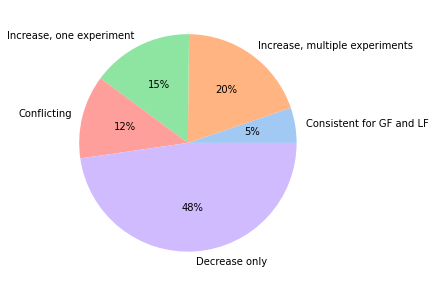

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
labels= [MAP_NAMES[x] for x in ALL_INFO.keys()]
data = []
for k, v in ALL_INFO.items():
    s = 0
    for _, l in v.items():
        s += len(l)
    data.append(s)

fig = plt.figure(figsize = (5, 5))

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(labels)]
#create pie chart
plt.pie(
    data,
    labels=labels,
    colors=colors,
    autopct='%.0f%%'
)
plt.show()

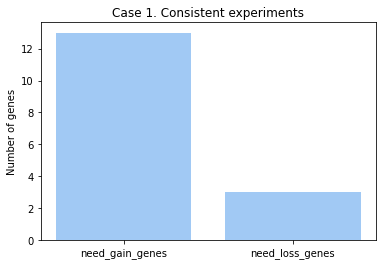

In [ ]:
plt.bar(
    x=list(ALL_INFO["case_1"].keys()),
    height=[len(v) for v in ALL_INFO["case_1"].values()],
    color=sns.color_palette('pastel')[0]
)
plt.ylabel("Number of genes")
plt.title(MAP_NAMES["case_1"])
plt.show()

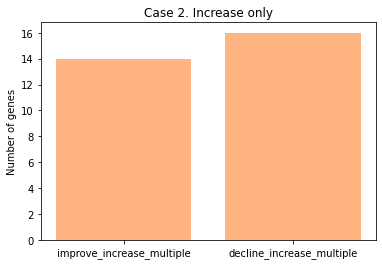

In [ ]:
plt.bar(
    x=list(ALL_INFO["case_2"].keys()),
    height=[len(v) for v in ALL_INFO["case_2"].values()],
    color=sns.color_palette('pastel')[1]
)
plt.ylabel("Number of genes")
plt.title(MAP_NAMES["case_2"])
plt.show()

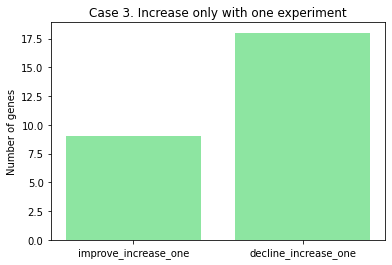

In [ ]:
plt.bar(
    x=list(ALL_INFO["case_3"].keys()),
    height=[len(v) for v in ALL_INFO["case_3"].values()],
    color=sns.color_palette('pastel')[2]
)
plt.ylabel("Number of genes")
plt.title(MAP_NAMES["case_3"])
plt.show()

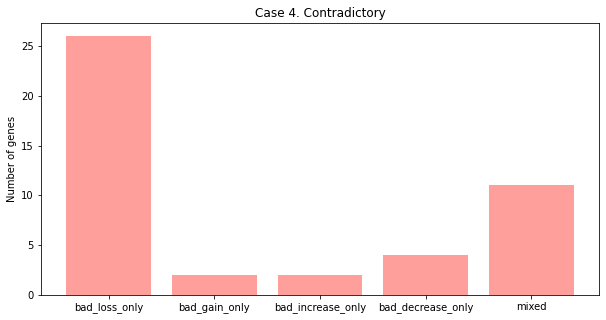

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.bar(
    x=list(ALL_INFO["case_4"].keys()),
    height=[len(v) for v in ALL_INFO["case_4"].values()],
    color=sns.color_palette('pastel')[3]
)
plt.ylabel("Number of genes")
plt.title(MAP_NAMES["case_4"])
plt.show()

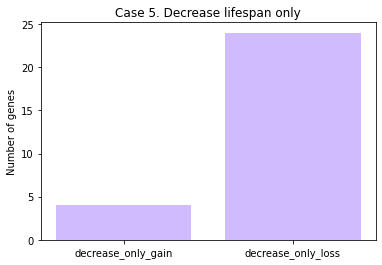

In [ ]:
plt.bar(
    x=list(ALL_INFO["case_5"].keys()),
    height=[len(v) for v in ALL_INFO["case_5"].values()],
    color=sns.color_palette('pastel')[4]
)
plt.ylabel("Number of genes")
plt.title(MAP_NAMES["case_5"])
plt.show()